In [76]:
import os
import gc
import random

import numpy as np

import rasterio

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import Callable, Dict, Optional, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch import Tensor

from torchgeo.datasets import (RasterDataset, 
                               stack_samples, 
                               splits, 
                               random_bbox_splitting)

from torchgeo.samplers import RandomGeoSampler
from torchgeo.trainers import SemanticSegmentationTask

from torchinfo import summary
from torchmetrics.classification import MulticlassF1Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

from skimage.util import view_as_windows

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import SoftCrossEntropyLoss, FocalLoss

from pprint import pprint

from tqdm.auto import tqdm, trange

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = 'retina'

In [2]:
config = {
    'seed': 2024,
    'batch_size': 128,
    'epochs':30,
    'learning_rate': 1e-3,
    'num_classes': 3,    
    'ignore_index': 2,
    'in_channels':4, 
    'model': 'DeepLabV3Plus',
    'encoder_name': 'resnet50',
    'size': (224, 224),
    'length': 5_000,
    'patience': 10,
}

In [3]:
# https://pytorch.org/docs/stable/notes/randomness.html
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.use_deterministic_algorithms(mode=True)
    torch.backends.cudnn.benchmark = True # False

seed_everything(config['seed'])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading data

In [5]:
def load_tif_image(patch: str) -> Tuple[np.array, list]:
    with rasterio.open(patch, mode='r') as src:
        arr = src.read()
        img = np.moveaxis(arr, 0, -1)
        profile = src.profile

    return img, profile

In [6]:
### ref: https://medium.com/@byeonghyeokyu/torchgeo-an-introduction-to-object-detection-example-b0fd43e89649
def preprocess(sample):
    sample['image'] = sample['image'].float() / 255.0
    
    return sample

In [7]:
class SARImages(RasterDataset):

    filename_glob = '*.tif'
    is_image = True
    separate_files = False
    all_bands = ['VV', 'VH']

In [8]:
class SARLabels(RasterDataset):

    filename_glob = '*.tif'
    is_image = False
    all_bands = [0]

In [9]:
# Load SAR images
img_2018 = SARImages('./data/18210.tif')
img_2019 = SARImages('./data/19229.tif')
img_2020 = SARImages('./data/20218.tif')

# Load labels
train_label = SARLabels('./data/label_2019.tif')
test_label  = SARLabels('./data/label_2020.tif')

In [10]:
dataset  = img_2018 & img_2019 & train_label
test_data = img_2019 & img_2020 & test_label

### Preparing data to feed the model

In [11]:
# Split data into 70 % for training and 20 % for validation
train_data, valid_data, _ = random_bbox_splitting(dataset, fractions=[0.7, 0.2, 0.1])

In [12]:
# Prepare dataloaders
train_sampler = RandomGeoSampler(train_data, size=config['size'], length=config['length'])
trainloader = DataLoader(train_data, batch_size=config['batch_size'], sampler=train_sampler, collate_fn=stack_samples)

valid_sampler = RandomGeoSampler(valid_data, size=config['size'], length=config['length'])
validloader = DataLoader(valid_data, batch_size=config['batch_size'], sampler=valid_sampler, collate_fn=stack_samples)

test_sampler = RandomGeoSampler(test_data, size=config['size'], length=config['length'])
testloader = DataLoader(test_data, batch_size=config['batch_size'], sampler=test_sampler, collate_fn=stack_samples)

In [13]:
# Sanity check

sample = next(iter(trainloader))

sample['image'].shape, sample['mask'].shape

(torch.Size([128, 4, 224, 224]), torch.Size([128, 1, 224, 224]))

### Model architecture

In [14]:
model = getattr(smp, config['model'])(
    encoder_name=config['encoder_name'],    # Choose from various encoders (e.g., resnet18)
    encoder_weights='imagenet',             # Load pretrained encoder weights (optional)
    in_channels=config['in_channels'],
    classes=config['num_classes'],          # Number of segmentation classes
)

In [15]:
print(summary(model, 
              (config['batch_size'], 4, 224, 224),
              col_names=['input_size', 'num_params', 'trainable'],
              device='cpu'))

Layer (type:depth-idx)                                  Input Shape               Param #                   Trainable
DeepLabV3Plus                                           [128, 4, 224, 224]        --                        True
├─ResNetEncoder: 1-1                                    [128, 4, 224, 224]        --                        True
│    └─Conv2d: 2-1                                      [128, 4, 224, 224]        12,544                    True
│    └─BatchNorm2d: 2-2                                 [128, 64, 112, 112]       128                       True
│    └─ReLU: 2-3                                        [128, 64, 112, 112]       --                        --
│    └─MaxPool2d: 2-4                                   [128, 64, 112, 112]       --                        --
│    └─Sequential: 2-5                                  [128, 64, 56, 56]         --                        True
│    │    └─Bottleneck: 3-1                             [128, 64, 56, 56]         75,008       

In [16]:
def train_fn(model, dataloader, optimizer, criterion, epoch):

    scaler = torch.cuda.amp.GradScaler()       # deal with out of memory    
    
    model.train()
    
    metric = MulticlassF1Score(num_classes=config['num_classes'], 
                               average='macro',
                               ignore_index=config['ignore_index']).to(device=device)
    
    running_loss = 0.0  
    for ii, sample in enumerate(tqdm(dataloader, leave=False)):
        images = sample['image'].to(device)
        labels = sample['mask'].squeeze().to(device)

        
        optimizer.zero_grad(set_to_none=True)  # set gradients to zero
        
        # Forward pass
        with torch.cuda.amp.autocast():        # autocasting
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass
        scaler.scale(loss).backward() 
        scaler.step(optimizer)
        scaler.update()

        # Set up scheduler
        # scheduler.step(epoch + ii / len(dataloader))
        # current_lr = scheduler.get_last_lr()[0]
        # wandb.log({f'current lerning rate - fold {fold}': current_lr})
        
        # Compute metrics
        running_loss += loss.item()
        metric.update(outputs, labels)
        
        # Garbage collection
        torch.cuda.empty_cache()
        _ = gc.collect()
        
    f1_macro = metric.compute()
    metric.reset()
    
    return running_loss / len(dataloader), f1_macro

In [17]:
@torch.no_grad()
def valid_fn(model, dataloader, criterion):
    
    model.eval() 
    
    metric = MulticlassF1Score(num_classes=config['num_classes'], 
                               average='macro',
                               ignore_index=config['ignore_index']).to(device=device)
    
    running_loss = 0.0

    for sample in tqdm(dataloader, leave=False):
        images = sample['image'].to(device)
        labels = sample['mask'].squeeze().to(device)
        
        with torch.cuda.amp.autocast():  # autocasting
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Compute metrics
        running_loss += loss.item()
        metric.update(outputs, labels)
        
        # Garbage collection
        torch.cuda.empty_cache()
        _ = gc.collect()
    
    f1_macro = metric.compute()
    metric.reset()

    return running_loss / len(dataloader), f1_macro

In [18]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.valid_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, valid_loss, model):

        score = -valid_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(valid_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(valid_loss, model)
            self.counter = 0

    def save_checkpoint(self, valid_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.valid_loss_min = valid_loss

In [19]:
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=config['ignore_index'])
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Training and evaluanting the model

In [20]:
%%time

history = {
    'valid_loss': [],
    'train_loss': [],
    'train_f1': [],
    'valid_f1': [],
}

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=config['patience'], verbose=True)

for epoch in (pbar := trange(config['epochs'])):
        
    train_loss, train_f1 = train_fn(model, trainloader, optimizer, criterion, epoch)
    valid_loss, valid_f1 = valid_fn(model, validloader, criterion)

            
    print(f'Epoch {epoch + 1:>03}/{config["epochs"]} | ',
          f'Train loss: {train_loss:8.5f} | Train f1 macro: {train_f1:8.5f} | ', 
          f'Valid loss: {valid_loss:8.5f} | Valid f1 macro: {valid_f1:8.5f}')
    
    # early_stopping needs the validation loss to check if it has decresed,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_f1'].append(train_f1.item())
    history['valid_f1'].append(valid_f1.item())

    if early_stopping.early_stop:
        print("Early stopping")
        break


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 001/30 |  Train loss:  0.14768 | Train f1 macro:  0.42192 |  Valid loss:  3.76017 | Valid f1 macro:  0.25979
Validation loss decreased (inf --> 3.760170).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 002/30 |  Train loss:  0.02307 | Train f1 macro:  0.86594 |  Valid loss:  0.02924 | Valid f1 macro:  0.81050
Validation loss decreased (3.760170 --> 0.029242).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 003/30 |  Train loss:  0.01457 | Train f1 macro:  0.89931 |  Valid loss:  0.02976 | Valid f1 macro:  0.83429
EarlyStopping counter: 1 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 004/30 |  Train loss:  0.01046 | Train f1 macro:  0.92430 |  Valid loss:  0.03234 | Valid f1 macro:  0.82532
EarlyStopping counter: 2 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 005/30 |  Train loss:  0.00855 | Train f1 macro:  0.94049 |  Valid loss:  0.01652 | Valid f1 macro:  0.91845
Validation loss decreased (0.029242 --> 0.016521).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 006/30 |  Train loss:  0.00940 | Train f1 macro:  0.93329 |  Valid loss:  0.01083 | Valid f1 macro:  0.94960
Validation loss decreased (0.016521 --> 0.010825).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 007/30 |  Train loss:  0.00788 | Train f1 macro:  0.94162 |  Valid loss:  0.02328 | Valid f1 macro:  0.88872
EarlyStopping counter: 1 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 008/30 |  Train loss:  0.00678 | Train f1 macro:  0.95469 |  Valid loss:  0.02822 | Valid f1 macro:  0.87997
EarlyStopping counter: 2 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 009/30 |  Train loss:  0.00574 | Train f1 macro:  0.96264 |  Valid loss:  0.12114 | Valid f1 macro:  0.70695
EarlyStopping counter: 3 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 010/30 |  Train loss:  0.00818 | Train f1 macro:  0.93402 |  Valid loss:  0.02297 | Valid f1 macro:  0.86722
EarlyStopping counter: 4 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 011/30 |  Train loss:  0.00802 | Train f1 macro:  0.94007 |  Valid loss:  0.01399 | Valid f1 macro:  0.93602
EarlyStopping counter: 5 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 012/30 |  Train loss:  0.00860 | Train f1 macro:  0.95233 |  Valid loss:  0.02435 | Valid f1 macro:  0.89010
EarlyStopping counter: 6 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 013/30 |  Train loss:  0.00750 | Train f1 macro:  0.94265 |  Valid loss:  0.04042 | Valid f1 macro:  0.75016
EarlyStopping counter: 7 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 014/30 |  Train loss:  0.00759 | Train f1 macro:  0.94357 |  Valid loss:  0.04793 | Valid f1 macro:  0.75664
EarlyStopping counter: 8 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 015/30 |  Train loss:  0.00616 | Train f1 macro:  0.94904 |  Valid loss:  0.10976 | Valid f1 macro:  0.68687
EarlyStopping counter: 9 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 016/30 |  Train loss:  0.00563 | Train f1 macro:  0.95457 |  Valid loss:  0.03838 | Valid f1 macro:  0.79082
EarlyStopping counter: 10 out of 10
Early stopping
CPU times: user 10h 44min 5s, sys: 9min 28s, total: 10h 53min 34s
Wall time: 1h 28min 42s


### Training and validation metrics evolution

In [51]:
history['train_f1'] = [value.detach().cpu().item() for value in  history['train_f1']]
history['valid_f1'] = [value.detach().cpu().item() for value in  history['valid_f1']]

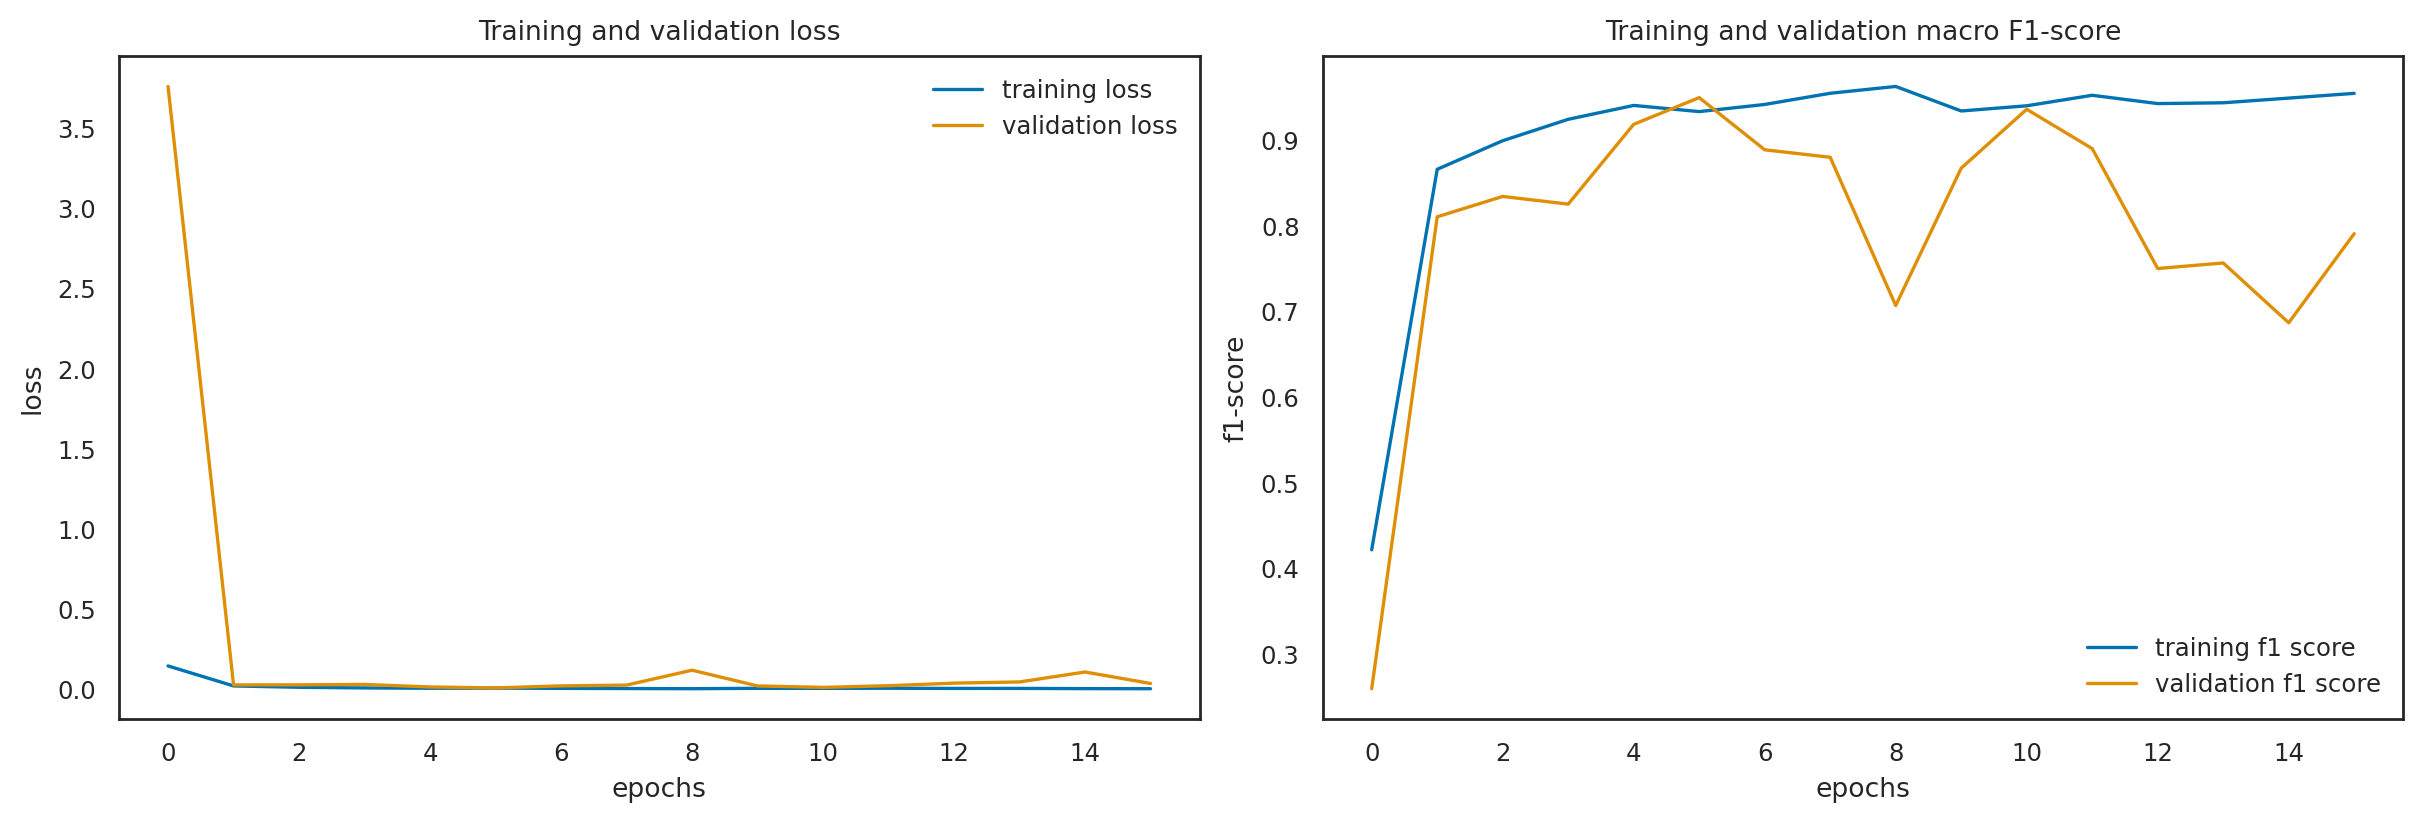

In [75]:
sns.set(context='paper', style='white', palette='colorblind')

fig, ax = plt.subplots(1, 2, figsize=[12, 4], layout='constrained')

sns.lineplot(history['train_loss'], label='training loss', ax=ax[0])
sns.lineplot(history['valid_loss'], label='validation loss', ax=ax[0])
ax[0].set(xlabel='epochs', ylabel='loss', title='Training and validation loss')
sns.move_legend(ax[0], loc='best', frameon=False)

sns.lineplot(history['train_f1'], label='training f1 score', ax=ax[1])
sns.lineplot(history['valid_f1'], label='validation f1 score', ax=ax[1])
ax[1].set(xlabel='epochs', ylabel='f1-score', title='Training and validation macro F1-score')
sns.move_legend(ax[1], loc='best', frameon=False);

In [21]:
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

### Predictions

In [22]:
@torch.no_grad()
def get_predictions(model, dataloader):
    
    model.eval() 
    
    metric = MulticlassF1Score(num_classes=config['num_classes'], 
                               average='macro', 
                               ignore_index=config['ignore_index']).to(device=device)
    
    y_true, y_pred = torch.tensor([], device=device), torch.tensor([], device=device) 
    running_loss = 0.0

    for sample in tqdm(dataloader, leave=False):
        images = sample['image'].to(device)
        labels = sample['mask'].squeeze().to(device) # , dtype=torch.long)
        
        with torch.cuda.amp.autocast():  # autocasting
            outputs = model(images)

        # Compute metrics
        metric.update(outputs, labels)
        
        # Compute metrics
        _, preds = torch.max(outputs, dim=1)
        
        y_true = torch.cat([y_true, labels], dim=0)
        y_pred = torch.cat([y_pred, preds], dim=0)
        
        # Garbage collection
        torch.cuda.empty_cache()
        _ = gc.collect()
        
    f1_macro = metric.compute()
    metric.reset()

    print(f'Test f1 macro: {f1_macro:.5f}')
    
    return y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy()

In [23]:
%%time

y_true, y_pred = get_predictions(model, testloader)

  0%|          | 0/40 [00:00<?, ?it/s]

Test f1 macro: 0.89210
CPU times: user 24min 9s, sys: 22.1 s, total: 24min 31s
Wall time: 3min 21s


In [25]:
# fig, ax = plt.subplots(2, 2, figsize=[12, 12], layout='constrained')

# ax[0, 0].imshow(y_true[0])
# ax[0, 1].imshow(y_pred[0])
# ax[1, 0].imshow(y_true[1])
# ax[1, 1].imshow(y_pred[1]);

In [26]:
y_true.shape, y_pred.shape

((5000, 224, 224), (5000, 224, 224))

In [27]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, jaccard_score, f1_score

In [28]:
# print(classification_report(y_true_, y_pred_))

In [29]:
# ConfusionMatrixDisplay.from_predictions(y_true_, y_pred_)

In [30]:
# jaccard_score(y_true, y_pred)